In [186]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
import matplotlib

from scipy.stats import skew
from scipy.stats.stats import pearsonr
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from subprocess import check_output
print(check_output(["ls", "../house_prices_advanced_regression_techniques"]).decode("utf8"))

sample_submission.csv
test.csv
train.csv
Untitled1.ipynb
Untitled.ipynb



In [187]:
%matplotlib inline

mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

#Import Data
data_train = pd.read_csv('train.csv')
data_test  = pd.read_csv('test.csv')

data_submit = pd.read_csv('sample_submission.csv')

data_train.head()
data_test.head()

#preview data
print (data_train.info())
print (data_test.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

,price,log(price + 1)
0,208500,12.247699
1,181500,12.109016
2,223500,12.317171
3,140000,11.849405
4,250000,12.429220


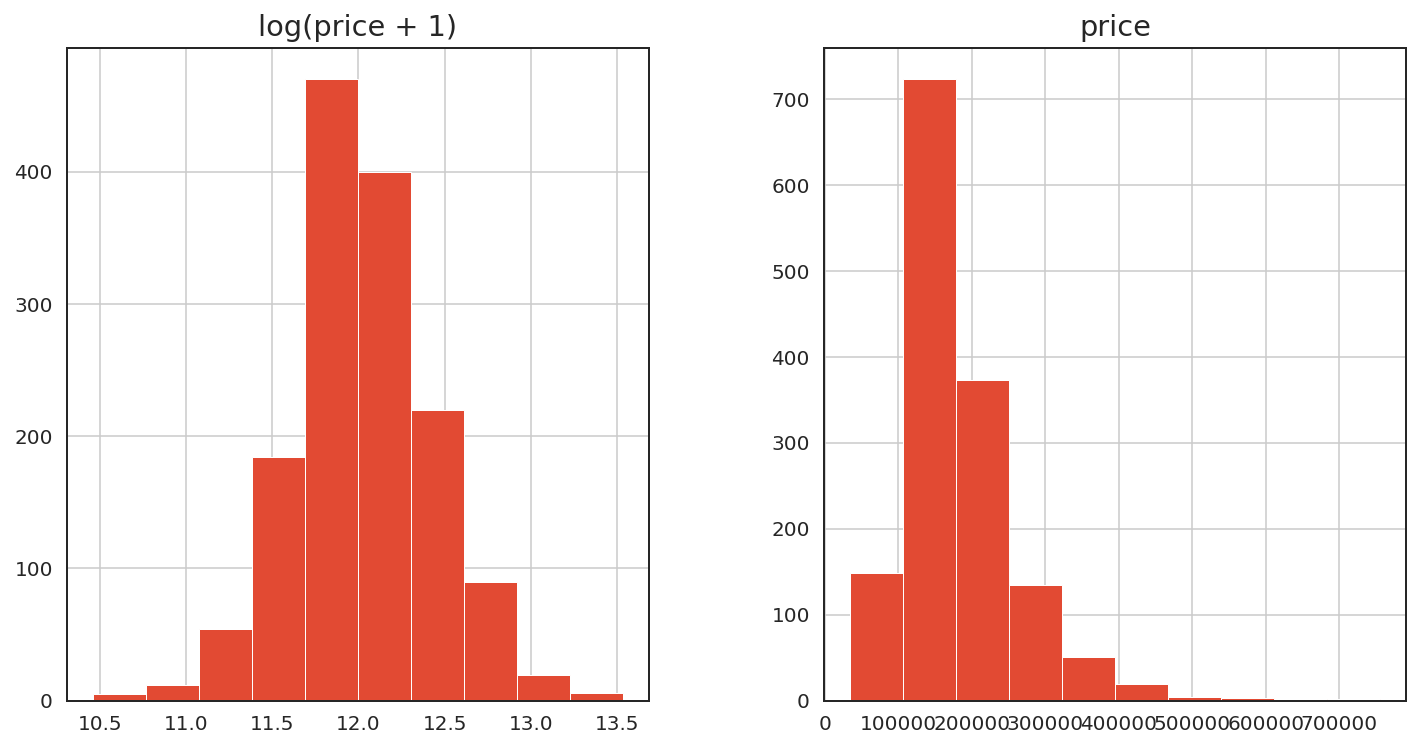

In [188]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":data_train["SalePrice"], "log(price + 1)":np.log1p(data_train["SalePrice"])})
prices.hist()
prices.head()

In [189]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge

ValueError: could not convert string to float: 'RL'

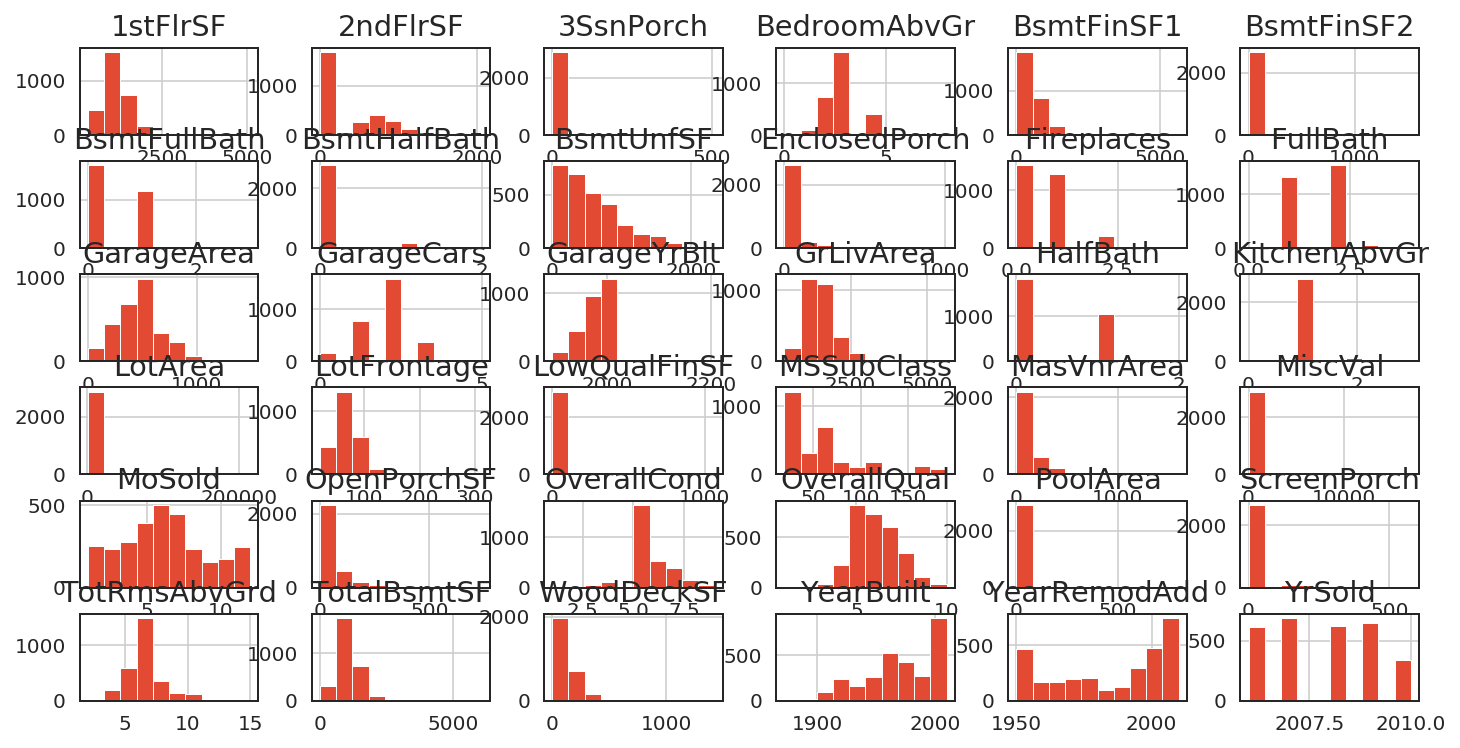

In [217]:


data = pd.concat([data_train.drop('SalePrice', axis=1), data_test], keys=['data_train', 'data_test'])
data.drop(['Id'], axis=1, inplace=True)
data.hist()
data.head()



In [191]:
years = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
metrics = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
         '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
         'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

In [192]:
data[years].max()

YearBuilt       2010.0
YearRemodAdd    2010.0
GarageYrBlt     2207.0
YrSold          2010.0
dtype: float64

In [193]:
mask = (data[years] > 2018).any(axis=1) # take any index with a twisted year value
data[mask]

,,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
data_test,1132,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2007,New,Partial


In [194]:
data.loc[mask, 'GarageYrBlt'] = data[mask]['YearBuilt']

In [195]:
mask = (data[metrics] < 0).any(axis=1)
data[mask]

,,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


In [185]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

TypeError: Unordered Categoricals can only compare equality or not

In [196]:
# Numerical features
num_feats = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
             'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 
             'BsmtQual', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
             'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
             'GrLivArea', 'FullBath', 'HalfBath',
             'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
             'Fireplaces', 'FireplaceQu', 'GarageYrBlt',
             'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
             'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
             'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal',
             'YrSold']    

#'BsmtFullBath', 'BsmtHalfBath'

# We need to convert literal grades to a numerical scale
grades = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
          'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
literal = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
#num = [9, 7, 5, 3, 2]
#G = dict(zip(literal, num))

#data[grades] = data[grades].replace(G)

# Categorical features: everything that is not 'numerical'
cat_feats = data.drop(num_feats, axis=1).columns

In [197]:
cat_feats

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir',
       'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'Functional',
       'GarageType', 'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature',
       'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')

In [198]:
#log transform the target:
price = np.log1p(train['SalePrice'])

#log transform skewed continuous numerical features:
skewed_feats = data.loc['data_train'][metrics].apply(lambda x: x.skew(skipna=True)) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

data[skewed_feats] = np.log1p(data[skewed_feats])

In [199]:
data.isnull().sum()[data.isnull().sum() > 0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [200]:
feats = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical', 'Functional',
         'SaleType']
model = data.loc['data_train'].groupby('Neighborhood')[feats].apply(lambda x: x.mode().iloc[0])

for f in feats:
    data[f].fillna(data['Neighborhood'].map(model[f]), inplace=True)

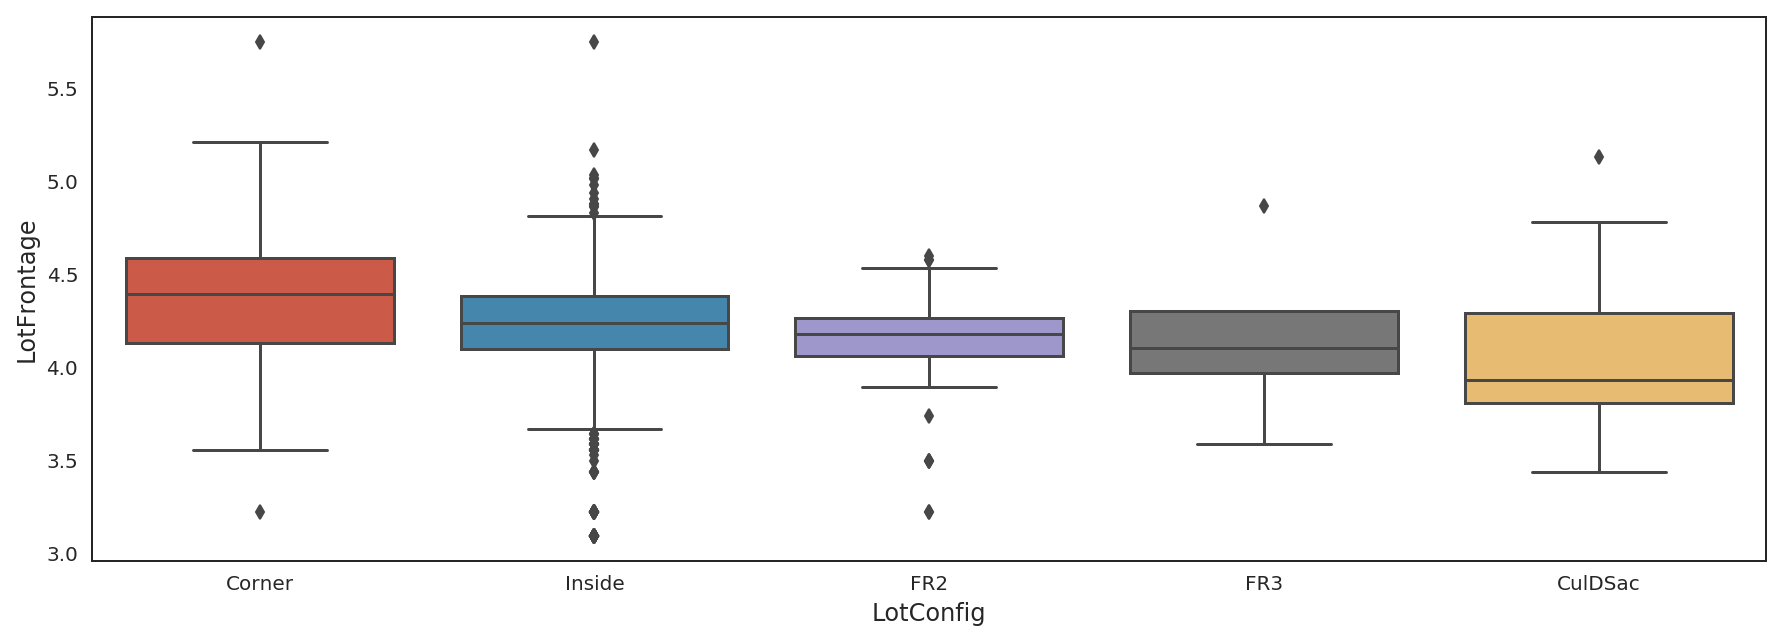

In [201]:
plt.subplots(figsize=(15,5))
boxdata = data.loc['data_train'].groupby('LotConfig')['LotFrontage'].median().sort_values(ascending=False)
order = boxdata.index
sns.boxplot(x='LotConfig', y='LotFrontage', order=order, data=data.loc['data_train'])

In [202]:
data['LotFrontage'] = data['LotFrontage'].fillna(data.loc['data_train', 'LotFrontage'].median())

In [203]:
data['KitchenQual'].fillna(data['OverallQual'], inplace=True)

In [204]:
bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 
        'BsmtHalfBath', 
        'TotalBsmtSF']
fire = ['Fireplaces', 'FireplaceQu']
garage = ['GarageQual', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageCars', 
          'GarageArea', 'GarageYrBlt']
masn = ['MasVnrType', 'MasVnrArea']
others = ['Alley', 'Fence', 'PoolQC', 'MiscFeature']

cats = data.columns[data.dtypes == 'object']
nums = list(set(data.columns) - set(cats))

# Be sure the category 'None' is also handled here
data['MasVnrType'].replace({'None': np.nan}, inplace=True)

data[cats] = data[cats].fillna('0')
data[nums] = data[nums].fillna(0)

In [205]:
data.isnull().sum().sum()

0

In [206]:
#data['MSSubClass'] = data['MSSubClass'].astype('object', copy=False)
#data['MoSold'] = data['MoSold'].astype('object', copy=False)
#data['BsmtFullBath'] = data['BsmtFullBath'].astype('int64', copy=False)
#data['BsmtHalfBath'] = data['BsmtHalfBath'].astype('int64', copy=False)
#data['GarageCars'] = data['GarageCars'].astype('int64', copy=False)
#data[years] = data[years].astype('int64', copy=False)

In [207]:
categorical_data = pd.concat((data.loc['data_train'][cat_feats], price), axis=1)

In [208]:
data.head()


MSSubClass MSZoning  LotFrontage   LotArea Street Alley  \
data_train 0          60       RL     4.189655  9.042040   Pave     0   
           1          20       RL     4.394449  9.169623   Pave     0   
           2          60       RL     4.234107  9.328212   Pave     0   
           3          70       RL     4.110874  9.164401   Pave     0   
           4          60       RL     4.442651  9.565284   Pave     0   

             LotShape LandContour Utilities LotConfig      ...        \
data_train 0      Reg         Lvl    AllPub    Inside      ...         
           1      Reg         Lvl    AllPub       FR2      ...         
           2      IR1         Lvl    AllPub    Inside      ...         
           3      IR1         Lvl    AllPub    Corner      ...         
           4      IR1         Lvl    AllPub       FR2      ...         

             ScreenPorch PoolArea PoolQC Fence MiscFeature MiscVal  MoSold  \
data_train 0         0.0      0.0      0     0           0     0.0       2   
           1         0.0      0.0      0     0           0     0.0       5   
           2         0.0      0.0      0     0           0     0.0       9   
           3         0.0      0.0      0     0           0     0.0       2   
           4         0.0      0.0      0     0           0     0.0      12   

              YrSold  SaleType  SaleCondition  
data_train 0    2008        WD         Normal  
           1    2007        WD         Normal  
           2    2008        WD         Normal  
           3    2006        WD        Abnorml  
           4    2008        WD         Normal  

[5 rows x 79 columns]

In [209]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [210]:
# Remove columns with just one category
for feat in categorical_data.columns[:-1]:    
    uni = categorical_data.groupby(feat).mean().sort_values(by='SalePrice').index
    if (len(uni) < 2):
            data.drop(feat, axis=1, inplace=True)
    elif len(uni) < 3:
        print("{}: {}".format(feat, uni))
        data[feat].replace({uni[0]: 0, uni[1]: 1}, inplace=True)
        data[feat] = data[feat].astype('int8')
    else:
        data[feat] = data[feat].astype('category')
        

Street: Index(['Grvl', 'Pave'], dtype='object', name='Street')
Utilities: Index(['NoSeWa', 'AllPub'], dtype='object', name='Utilities')
CentralAir: Index(['N', 'Y'], dtype='object', name='CentralAir')


In [211]:
finaldata = pd.get_dummies(data)

In [212]:
black_list = bsmt + fire + garage + masn + others
for feat in finaldata.columns:
    if ('_0' in feat) and (feat.split("_")[0] in black_list):
        finaldata.drop(feat, axis=1, inplace=True)

In [213]:
finaldata.shape

(2919, 315)

In [215]:
#m = X_train.mean()
#std = X_train.std()

#X_train = (X_train - m) / std
#X_test = (X_test - m) / std

In [216]:
# Training/testing sets
X_test = finaldata.loc['data_test']
X_train = finaldata.loc['data_train']

y_train = price
# Create linear regression object
LR = LinearRegression()

# Train the model using the training sets
LR.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').